# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option("display.max_colwidth", -1)
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf

In [2]:
#seeding
seed = 2021
np.random.seed = seed
tf.seed = seed

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maksahu","key":"cff8c0f086aa6e0e50553f7ab0580687"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Data

In [5]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 89.7MB/s]
 66% 6.00M/9.10M [00:00<00:00, 61.3MB/s]
100% 9.10M/9.10M [00:00<00:00, 58.3MB/s]
 83% 66.0M/79.1M [00:00<00:00, 79.7MB/s]
100% 79.1M/79.1M [00:00<00:00, 161MB/s] 
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 119MB/s]
 96% 266M/276M [00:05<00:00, 72.0MB/s]
100% 276M/276M [00:05<00:00, 49.1MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.57MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 116MB/s]


In [6]:
#Creating these two folder
!mkdir train test

In [7]:
#Unziping the training and testing folders into directories
print('Unzipping stage1_train.zip')
!unzip -q "/content/stage1_train.zip" -d train/
print('Unzipped stage1_train.zip')

print('Unzipping stage1_test.zip')
!unzip -q "/content/stage1_train.zip" -d test/
print('Unzipped stage1_test.zip')

Unzipping stage1_train.zip
Unzipped stage1_train.zip
Unzipping stage1_test.zip
Unzipped stage1_test.zip


In [8]:
# Root directories for training and testing
TRAIN_ROOT = './train'
TEST_ROOT = './test'

In [9]:
# Function to create a dataframe of files which will be used for further processing
def files_df(root_dir):
    subdir = os.listdir(root_dir)
    files = []
    df = pd.DataFrame()
    for dir in subdir:
        files.append(os.path.join(root_dir,dir))
    df['files'] = files
    return df

In [10]:
train_df = files_df(TRAIN_ROOT)
test_df = files_df(TEST_ROOT)

In [11]:
# Hyperparameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
CLASSES = 1
BATCH_SIZE = 8

In [12]:
# Function which will create a dataframe of image paths and mask paths along with creating a single mask with multiple masks
def image_df(filenames):
    image_paths = []
    mask_paths = []
    df = pd.DataFrame()
    for filename in tqdm(filenames):
        file_path = os.path.join(filename,'images')
        image_path = os.path.join(file_path,os.listdir(file_path)[0])
        image_paths.append(image_path)
        
        mask = np.zeros((IMG_WIDTH,IMG_HEIGHT,CLASSES))
        mask_dir = file_path.replace("images", "masks")
        masks = os.listdir(mask_dir)
        for m in masks:
            mask_path = os.path.join(mask_dir,m)
            mask_  = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            mask_  = cv2.resize(mask_,(IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_NEAREST)
            mask_  = np.expand_dims(mask_, axis = -1)
            mask = np.maximum(mask,mask_)
        newmask_dir = mask_dir.replace("masks", "masks_")
        if not os.path.isdir(newmask_dir):
            os.mkdir(newmask_dir)
        newmask_path = image_path.replace("images", "masks_")
        mask_paths.append(newmask_path)
        cv2.imwrite(newmask_path, mask)
    df['images'] = image_paths
    df['masks'] = mask_paths
    return df

In [13]:
# Training dataframe
train_filenames = train_df['files']
train = image_df(train_filenames)

100%|██████████| 670/670 [00:26<00:00, 24.85it/s]


In [14]:
train.head()

,images,masks
0,./train/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db/images/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db.png,./train/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db/masks_/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db.png
1,./train/e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c/images/e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c.png,./train/e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c/masks_/e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c.png
2,./train/5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3/images/5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3.png,./train/5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3/masks_/5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3.png
3,./train/ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6/images/ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6.png,./train/ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6/masks_/ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6.png
4,./train/2c840a94d216f5ef4e499b53ae885e9b022cbf639e004ec788436093837823b2/images/2c840a94d216f5ef4e499b53ae885e9b022cbf639e004ec788436093837823b2.png,./train/2c840a94d216f5ef4e499b53ae885e9b022cbf639e004ec788436093837823b2/masks_/2c840a94d216f5ef4e499b53ae885e9b022cbf639e004ec788436093837823b2.png


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
unet_model = tf.keras.models.load_model("/content/drive/MyDrive/CaseStudy2/unet_model.h5")
hrnet_model = tf.keras.models.load_model("/content/drive/MyDrive/CaseStudy2/hrnet_model.h5")

# EDA

In [17]:
# Custom MeanIoU Metric function
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, thres=0.5, name='mean_iou', dtype=None):
        super(MeanIoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.thres = thres
        self.total_cm = self.add_weight('total_confusion_matrix',
                                        shape=(num_classes, num_classes),
                                        initializer=tf.zeros_initializer())

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])
        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])
        
        y_pred = tf.where(y_pred > self.thres, 1.0, 0.0)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self._dtype)
            if sample_weight.shape.ndims > 1:
                sample_weight = tf.reshape(sample_weight, [-1])
        current_cm = tf.math.confusion_matrix(y_true,
                                              y_pred,
                                              self.num_classes,
                                              weights=sample_weight,
                                              dtype=self._dtype)
        
        return self.total_cm.assign_add(current_cm)

    def result(self):
        sum_over_row = tf.cast(tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)
        denominator = sum_over_row + sum_over_col - true_positives
        num_valid_entries = tf.reduce_sum(tf.cast(tf.math.not_equal(denominator, 0), dtype=self._dtype))
        iou = tf.math.divide_no_nan(true_positives, denominator)
        return tf.math.divide_no_nan(tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)
    
    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        tf.keras.backend.set_value(self.total_cm, np.zeros((self.num_classes, self.num_classes)))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(MeanIoU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [18]:
# Function to create a dataframe with iou_scores for each model and image and mask paths.
def metric_df(data):
    unet_iou_scores = []
    hrnet_iou_scores = []
    m = MeanIoU(2, 0.4)
    for i in tqdm(range(len(data))):
        
        image_path = data['images'].iloc[i]
        mask_path = data['masks'].iloc[i]
        image_string = tf.io.read_file(image_path)
        image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
        mask_string = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask_string, channels=CLASSES)#
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
        
        pred_mask_u = unet_model.predict(image[np.newaxis,:,:,:])
        m.update_state(mask, pred_mask_u)
        u_iou_score = m.result().numpy()
        unet_iou_scores.append(round(u_iou_score,4))
        
        pred_mask_h = hrnet_model.predict(image[np.newaxis,:,:,:])
        m.update_state(mask, pred_mask_h)
        h_iou_score = m.result().numpy()
        hrnet_iou_scores.append(round(h_iou_score,4))
        
        
    data['unet_iou_scores'] = unet_iou_scores
    data['hrnet_iou_scores'] = hrnet_iou_scores
    return data

In [19]:
df = train.copy()
df = metric_df(df)
df = df.sort_values(by=['hrnet_iou_scores','unet_iou_scores'])
df.head()

100%|██████████| 670/670 [02:14<00:00,  5.00it/s]


,images,masks,unet_iou_scores,hrnet_iou_scores
3,./train/ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6/images/ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6.png,./train/ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6/masks_/ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6.png,0.9147,0.9151
8,./train/44ab6a09eedee848b072ea3acd0f4e781f9c43b8d4e3d62598e1024584bf0b01/images/44ab6a09eedee848b072ea3acd0f4e781f9c43b8d4e3d62598e1024584bf0b01.png,./train/44ab6a09eedee848b072ea3acd0f4e781f9c43b8d4e3d62598e1024584bf0b01/masks_/44ab6a09eedee848b072ea3acd0f4e781f9c43b8d4e3d62598e1024584bf0b01.png,0.9153,0.9165
6,./train/4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607/images/4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607.png,./train/4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607/masks_/4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607.png,0.9169,0.9165
14,./train/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/images/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7.png,./train/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7/masks_/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7.png,0.9174,0.9179
15,./train/212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6/images/212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6.png,./train/212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6/masks_/212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6.png,0.9180,0.9182


In [20]:
df.tail()

,images,masks,unet_iou_scores,hrnet_iou_scores
32,./train/97158b2fe38783d88d4e44ba1b7bc6c84f225f8b35fcccc2f9265c65f14e7c8b/images/97158b2fe38783d88d4e44ba1b7bc6c84f225f8b35fcccc2f9265c65f14e7c8b.png,./train/97158b2fe38783d88d4e44ba1b7bc6c84f225f8b35fcccc2f9265c65f14e7c8b/masks_/97158b2fe38783d88d4e44ba1b7bc6c84f225f8b35fcccc2f9265c65f14e7c8b.png,0.9321,0.9323
33,./train/673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989/images/673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989.png,./train/673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989/masks_/673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989.png,0.9322,0.9323
30,./train/5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8/images/5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8.png,./train/5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8/masks_/5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8.png,0.9322,0.9326
1,./train/e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c/images/e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c.png,./train/e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c/masks_/e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c.png,0.9340,0.9331
0,./train/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db/images/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db.png,./train/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db/masks_/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db.png,0.9587,0.9625


## Best Output samples

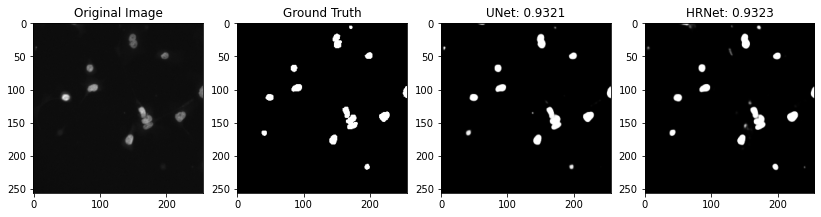

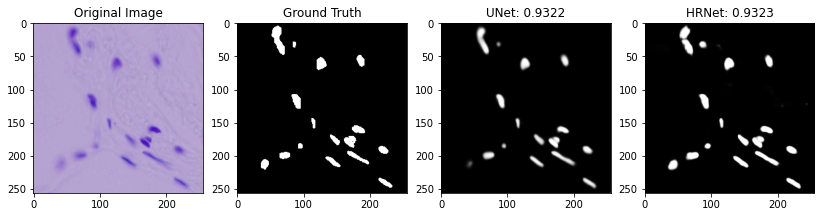

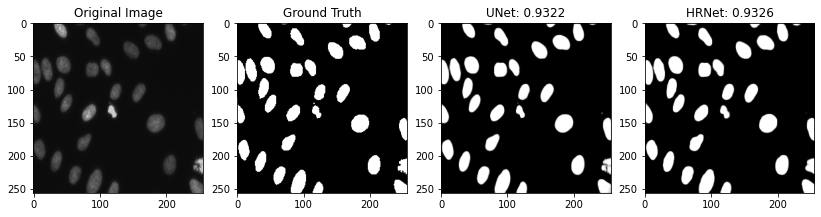

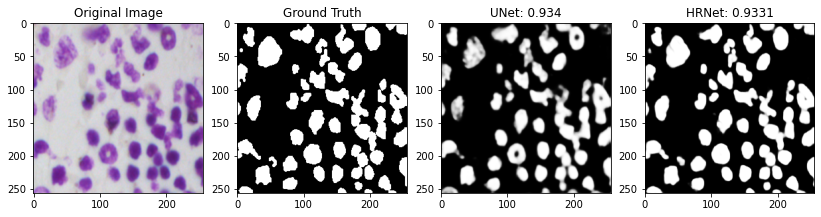

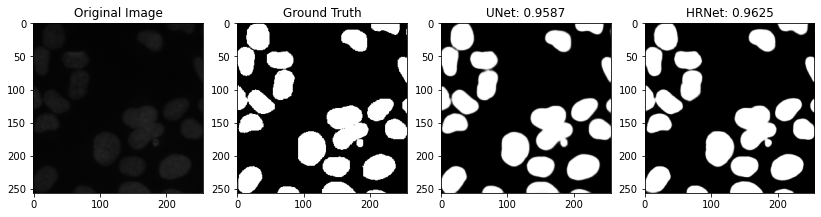

In [21]:
d1 = df.tail()
for i in range(5):
    image_path = d1['images'].iloc[i]
    mask_path = d1['masks'].iloc[i]
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=CLASSES)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    
    pred_mask_u  = unet_model.predict(image[np.newaxis,:,:,:])
    pred_mask_h  = hrnet_model.predict(image[np.newaxis,:,:,:])
    
    fig = plt.figure(figsize=(14,10))    
    ax1 = fig.add_subplot(141)
    ax1.title.set_text('Original Image')    
    ax1.imshow(image)
    ax2 = fig.add_subplot(142)
    ax2.title.set_text('Ground Truth')    
    ax2.imshow(mask[:,:,0], cmap='gray')
    ax3 = fig.add_subplot(143)
    ax3.title.set_text('UNet: '+ str(round(d1['unet_iou_scores'].iloc[i],4)))    
    ax3.imshow(pred_mask_u[0,:,:,0], cmap='gray')
    ax4 = fig.add_subplot(144)
    ax4.title.set_text('HRNet: '+ str(round(d1['hrnet_iou_scores'].iloc[i],4)))    
    ax4.imshow(pred_mask_h[0,:,:,0], cmap='gray')
    plt.show()

## Worst Output Samples

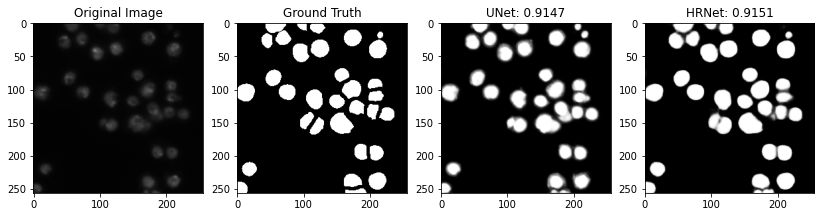

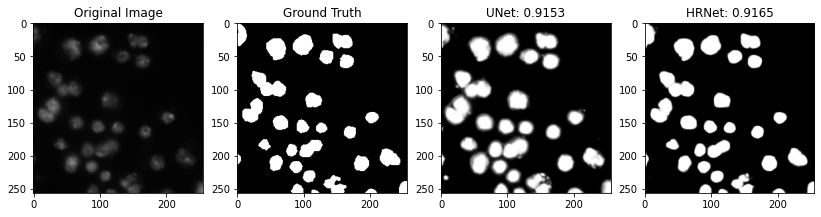

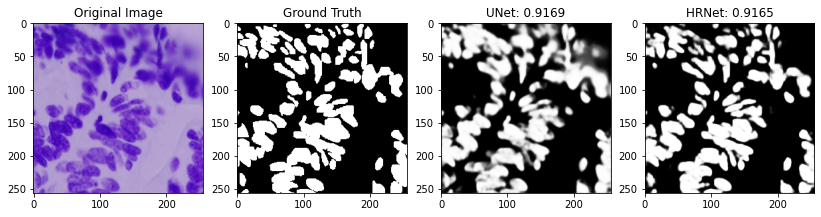

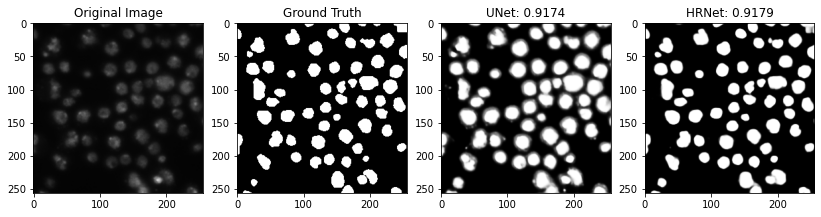

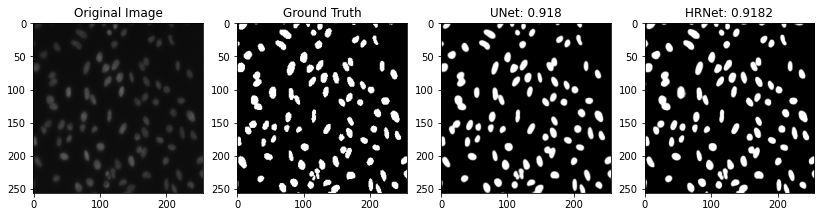

In [22]:
d2 = df.head()
for i in range(5):
    image_path = d2['images'].iloc[i]
    mask_path = d2['masks'].iloc[i]
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
    
    mask_string = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_string, channels=CLASSES)#
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    
    pred_mask_u  = unet_model.predict(image[np.newaxis,:,:,:])
    pred_mask_h  = hrnet_model.predict(image[np.newaxis,:,:,:])
    
    fig = plt.figure(figsize=(14,10))    
    ax1 = fig.add_subplot(141)
    ax1.title.set_text('Original Image')    
    ax1.imshow(image)
    ax2 = fig.add_subplot(142)
    ax2.title.set_text('Ground Truth')    
    ax2.imshow(mask[:,:,0], cmap='gray')
    ax3 = fig.add_subplot(143)
    ax3.title.set_text('UNet: '+ str(round(d2['unet_iou_scores'].iloc[i],4)))    
    ax3.imshow(pred_mask_u[0,:,:,0], cmap='gray')
    ax4 = fig.add_subplot(144)
    ax4.title.set_text('HRNet: '+ str(round(d2['hrnet_iou_scores'].iloc[i],4)))    
    ax4.imshow(pred_mask_h[0,:,:,0], cmap='gray')
    plt.show()

## Distribution of 'iou_scores'

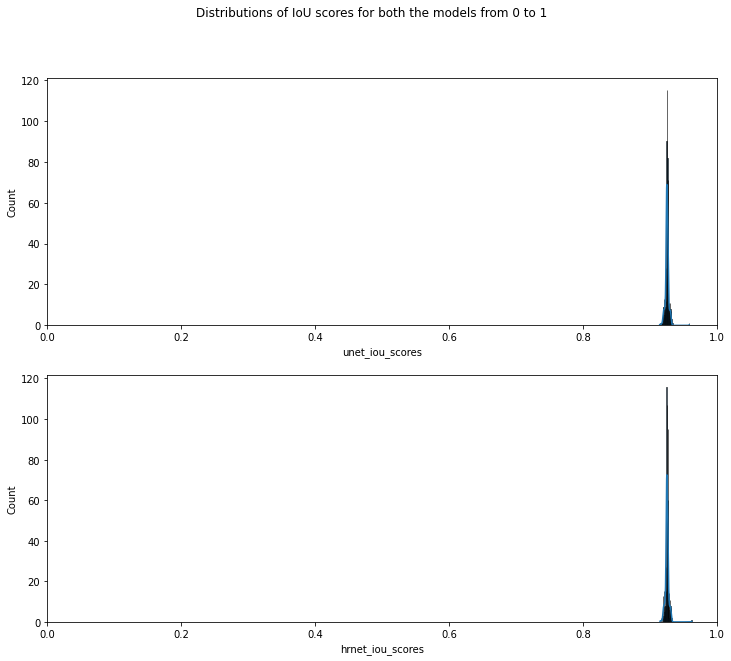

In [23]:
f, axes = plt.subplots(2, 1, figsize=(12,10))
sns.histplot(data=df, x="unet_iou_scores",kde=True, ax=axes[0])
sns.histplot(data=df, x="hrnet_iou_scores",kde=True, ax=axes[1])
axes[0].set_xlim(0, 1)
axes[1].set_xlim(0, 1)
plt.suptitle("Distributions of IoU scores for both the models from 0 to 1")
plt.show()

- The above plot is not providing much information.
- We will zoom it than.

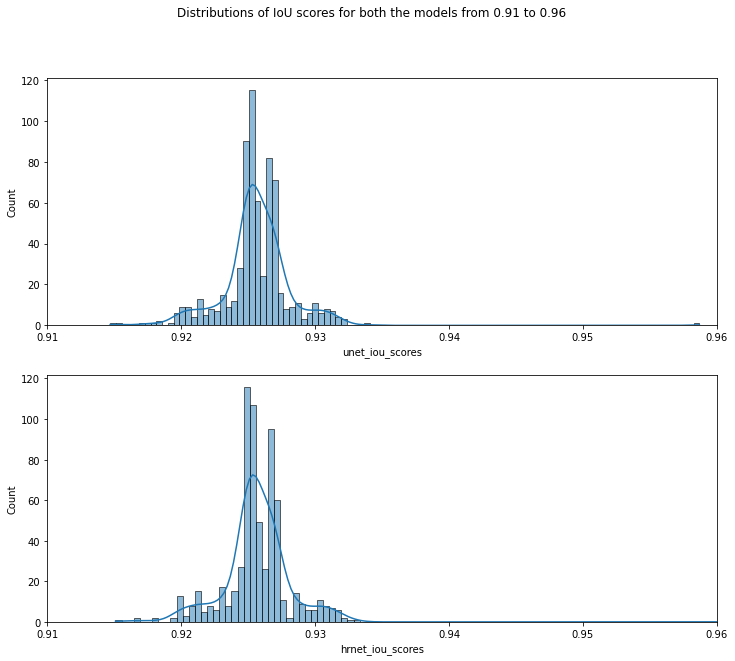

In [24]:
f, axes = plt.subplots(2, 1, figsize=(12,10))
sns.histplot(data=df, x="unet_iou_scores",kde=True, ax=axes[0])
sns.histplot(data=df, x="hrnet_iou_scores",kde=True, ax=axes[1])
axes[0].set_xlim(0.91, 0.96)
axes[1].set_xlim(0.91, 0.96)
plt.suptitle("Distributions of IoU scores for both the models from 0.91 to 0.96")
plt.show()

- Above two plots seem almost identical.
- Points having iou score greater than 0.93 for the case of HRNet seems to be slightly more than UNet.

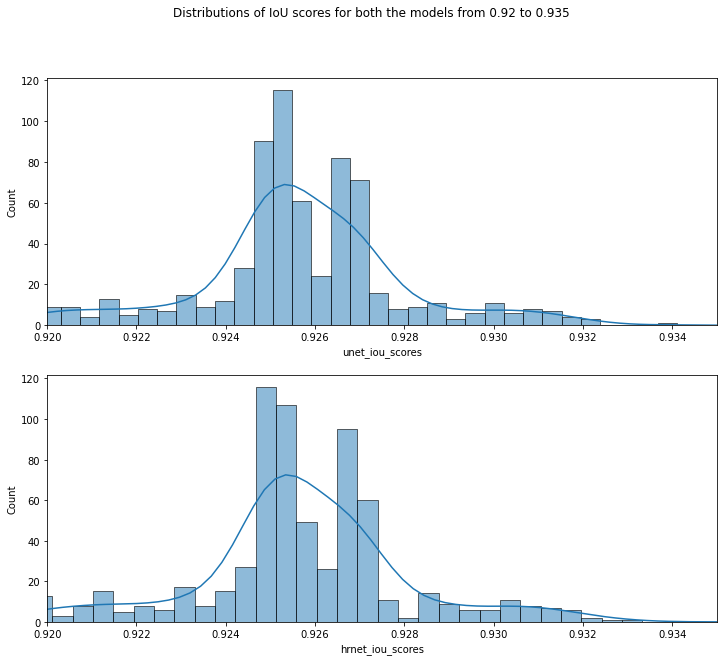

In [25]:
f, axes = plt.subplots(2, 1, figsize=(12,10))
sns.histplot(data=df, x="unet_iou_scores",kde=True, ax=axes[0])
sns.histplot(data=df, x="hrnet_iou_scores",kde=True, ax=axes[1])
axes[0].set_xlim(0.92, 0.935)
axes[1].set_xlim(0.92, 0.935)
plt.suptitle("Distributions of IoU scores for both the models from 0.92 to 0.935")
plt.show()

- From the above plot we can see that there are more points after 0.93 for the case of HRNet than UNet.

In [26]:
num_great = len(df[df['hrnet_iou_scores'] > df['unet_iou_scores']])
num_less = len(df[df['hrnet_iou_scores'] < df['unet_iou_scores']])
print('Number of points for which HRNet performed better: ', num_great)
print('Number of points for which UNet performed better: ', num_less)

Number of points for which HRNet performed better:  251
Number of points for which UNet performed better:  56


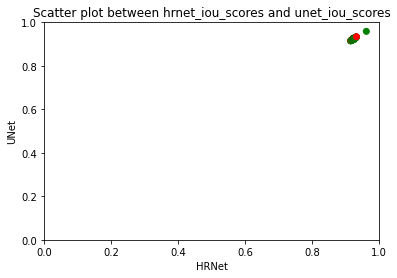

In [27]:
x = df['hrnet_iou_scores']
y = df['unet_iou_scores']
col = np.where(x<y,'red','green')
fig, ax = plt.subplots()
ax.scatter(x, y, c=col)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('HRNet')
plt.ylabel('UNet')
plt.title('Scatter plot between hrnet_iou_scores and unet_iou_scores')
plt.show()

- Scatter plot between iou scores of two models.
- Green color signifies points where HRNet gave better iou score than UNet.
- Red color signifies points where UNet gave better iou score than HRNet.

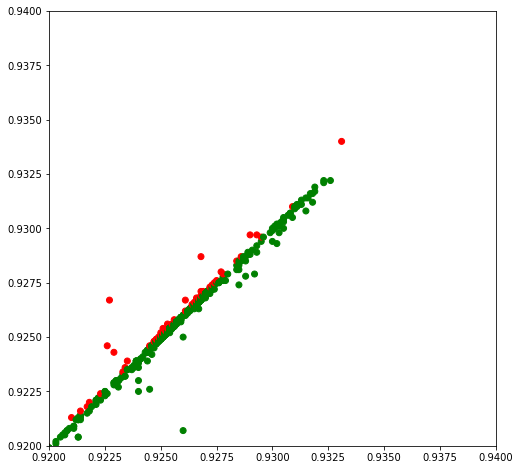

In [28]:
x = df['hrnet_iou_scores']
y = df['unet_iou_scores']
col = np.where(x<y,'red','green')
fig, ax = plt.subplots(figsize=(8,8))#
ax.scatter(x, y, c=col)
plt.xlim(0.92,0.94)
plt.ylim(0.92,0.94)
plt.show()

- Zooming the scatter plot we can see that there are more green points than red points.
- This signifies that HRNet has performed better than UNet.
- We can see points where UNet performed better is spread across the range.

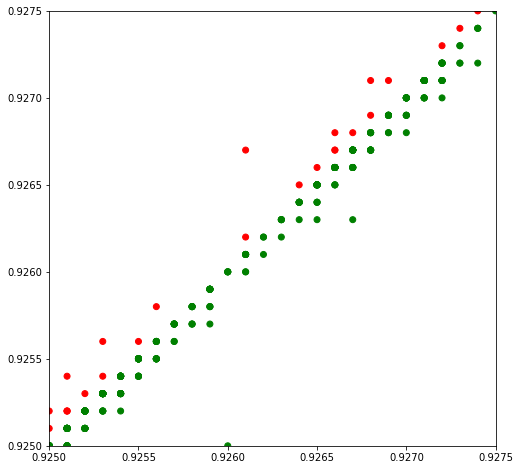

In [29]:
x = df['hrnet_iou_scores']
y = df['unet_iou_scores']
col = np.where(x<y,'red','green')
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, c=col)
plt.xlim(0.925,0.9275)
plt.ylim(0.925,0.9275)
plt.show()

- In this plot we can see that although HRNet has performed better than UNet but the difference is very small.